<a href="https://colab.research.google.com/github/kamg2218/Data-Analysis-with-Open-Source/blob/main/%EC%98%A4%ED%94%88%EC%86%8C%EC%8A%A4_%EB%8D%B0%EC%9D%B4%ED%84%B0_%EB%B6%84%EC%84%9D_12%EA%B0%95.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 12강 정형 데이터 분석 : 서울시 공공 자전거 데이터 활용

### 목표

공공 자전거 이용 특성을 파악하고, 날씨와 자전거 이용량의 상관관계를 분석하여 데이터 기반의 정책 수립에 필요한 인사이트를 도출

### 분석 프로세스 개요

1. 데이터 수집 및 전처리
  - CSV 형태의 데이터 수집
  - 기초 통계량 산출
  - 결측치 처리 및 이상치 제거
  - 날짜/시간 데이터 형식 변환
2. 데이터 분석
  - 시계열 패턴 분석
3. 연계 분석
  - 강수량 데이터와의 연계 분석
  - 상관관계 분석
  - 정책 제언으로 연결

In [ ]:
# 한글 처리를 위한 matplotlib 설정 (1)

!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

- 런타임 -> 세션 다시 시작

In [1]:
# 한글 처리를 위한 matplotlib 설정 (2)

import matplotlib.pyplot as plt
plt.rc('font', family='NanumBarunGothic')

# 1. 데이터 수집 및 전처리

### 12-1 따릉이 대역 기록 2023-04 업로드 및 압축 해제

- 따릉이 데이터 다운로드
  - [서울 열린데이터 광장](https://data.seoul.go.kr)
  - 검색어 : 따릉이
  - 서울시 따릉이 대여소별 대여/반납 승객수 정보
  - 2023-04 다운로드 후 업로드

In [ ]:
!unzip tpss_bcycl_od_statnhm_202510.zip -d tpss_bcycl_od_statnhm_202510

## 12-2 CSV 형태의 데이터 수집

In [9]:
import glob
import pandas as pd

## CSV 파일 목록 가져오기
all_files = glob.glob("tpss_bcycl_od_statnhm_202510/*.csv")
dataframes = []
for filename in all_files:
    ## CSV 파일 읽어서 데이터프레임화
    df = pd.read_csv(filename, encoding='cp949')
    dataframes.append(df)
## 모든 데이터프레임 결합
df = pd.concat(dataframes, axis=0, ignore_index=True)

## 상위 5행 출력
df.head(5)

,기준_날짜,집계_기준,기준_시간대,시작_대여소_ID,시작_대여소명,종료_대여소_ID,종료_대여소명,전체_건수,전체_이용_분,전체_이용_거리
0,20251011,출발시간,1740,ST-2876,방이2동_005_1,ST-1041,성내1동_012_1,1,12.0,1631.0
1,20251011,출발시간,1515,ST-2987,문정2동_031_1,ST-1186,수서동_023_1,1,8.0,1380.0
2,20251011,출발시간,1605,ST-237,행당1동_007_1,ST-237,행당1동_007_1,1,76.0,4580.0
3,20251011,출발시간,1535,ST-761,서초2동_004_2,ST-742,내곡동_006_3,1,77.0,11702.0
4,20251011,출발시간,1650,ST-2033,가양1동_012_7,ST-2487,등촌1동_033_1,1,17.0,2468.0


## 12-3 기초 통계량 산출

In [11]:
## 수치형 데이터 요약 통계 출력
print(df.describe())
## 범주형 데이터 요약 통계 출력
print(df.describe(include=['object']).to_markdown())

              기준_날짜        기준_시간대         전체_건수       전체_이용_분      전체_이용_거리
count  6.295731e+06  6.295731e+06  6.295731e+06  6.077345e+06  6.077345e+06
mean   2.025102e+07  1.424761e+03  1.062746e+00  2.327829e+01  2.629289e+03
std    9.219386e+00  5.522030e+02  2.811767e-01  3.135246e+01  3.485931e+03
min    2.025100e+07  0.000000e+00  1.000000e+00  1.000000e+00  3.000000e+02
25%    2.025101e+07  9.550000e+02  1.000000e+00  6.000000e+00  8.780000e+02
50%    2.025102e+07  1.525000e+03  1.000000e+00  1.200000e+01  1.512000e+03
75%    2.025102e+07  1.840000e+03  1.000000e+00  2.700000e+01  2.852000e+03
max    2.025103e+07  2.355000e+03  1.400000e+01  7.715000e+03  2.655060e+05
|        | 집계_기준   | 시작_대여소_ID   | 시작_대여소명   | 종료_대여소_ID   | 종료_대여소명   |
|:-------|:------------|:-----------------|:----------------|:-----------------|:----------------|
| count  | 6295731     | 6295731          | 6290286         | 6295731          | 6261658         |
| unique | 2           | 2771             | 2

## 12-4 결측치 및 이상치 제거

In [16]:
## 결측치 제거
df = df.dropna()
## '전체_이용_분' 컬럼 값 필터링 (1분 이하, 180분 이상 제거)
df = df[(df['전체_이용_분'] > 1) & (df['전체_이용_분'] < 180)]
## '전체_이용_거리' 컬럼 값 필터링 (10M 이하, 10000M 이상 제거)
df = df[(df['전체_이용_거리'] > 10) & (df['전체_이용_거리'] < 10000)]

## '집계_기준' 컬럼 필터링 (출발시간만 사용)
df = df[df['집계_기준'] == '출발시간']

print(df.describe())

              기준_날짜         기준_시간대          전체_건수        전체_이용_분  \
count  9.198780e+05  919878.000000  919878.000000  919878.000000   
mean   2.025102e+07    1381.908731       1.009448       8.076883   
std    9.173333e+00     553.050668       0.100326      13.600039   
min    2.025100e+07       0.000000       1.000000       2.000000   
25%    2.025101e+07     910.000000       1.000000       4.000000   
50%    2.025102e+07    1435.000000       1.000000       5.000000   
75%    2.025102e+07    1825.000000       1.000000       7.000000   
max    2.025103e+07    2355.000000       7.000000     179.000000   

            전체_이용_거리  
count  919878.000000  
mean      683.359580  
std       186.325059  
min       300.000000  
25%       536.000000  
50%       692.000000  
75%       840.000000  
max       999.000000  


## 12-5 날짜/시간 데이터 형식 변환

In [21]:
## '기준_날짜' 컬럼 datetime 형식으로 변환 (%Y%m%d)
df['기준_날짜'] = pd.to_datetime(df['기준_날짜'], format='%Y%m%d')

## '요일' 컬럼 생성
day_mapping = {
    'Monday': '월요일',
    'Tuesday': '화요일',
    'Wednesday': '수요일',
    'Thursday': '목요일',
    'Friday': '금요일',
    'Saturday': '토요일',
    'Sunday': '일요일'
}

df['요일'] = df['기준_날짜'].dt.day_name().map(day_mapping)

## 전처리 결과 확인

In [22]:
## 수치형 데이터 요약 통계 출력
print("수치형 데이터 요약 통계:\n", df.describe().to_markdown())
## 범주형 데이터 요약 통계 출력
print("\n범주형 데이터 요약 통계:\n", df.describe(include=['object']).to_markdown())

수치형 데이터 요약 통계:
 |       | 기준_날짜                     |   기준_시간대 |     전체_건수 |   전체_이용_분 |   전체_이용_거리 |
|:------|:------------------------------|--------------:|--------------:|---------------:|-----------------:|
| count | 919878                        |    919878     | 919878        |   919878       |       919878     |
| mean  | 2025-10-17 19:02:53.691728896 |      1381.91  |      1.00945  |        8.07688 |          683.36  |
| min   | 2025-10-01 00:00:00           |         0     |      1        |        2       |          300     |
| 25%   | 2025-10-12 00:00:00           |       910     |      1        |        4       |          536     |
| 50%   | 2025-10-19 00:00:00           |      1435     |      1        |        5       |          692     |
| 75%   | 2025-10-25 00:00:00           |      1825     |      1        |        7       |          840     |
| max   | 2025-10-31 00:00:00           |      2355     |      7        |      179       |          999     |
| std   | nan     

# 2. 데이터 분석

## 12-6 요일별 이용량 분석

In [24]:
## 요일별 이용량 계산 및 정렬
day_df = df['요일'].value_counts().reindex(day_mapping.values())
## 요일별 이용량 출력
print("요일별 이용량:\n", day_df)

요일별 이용량:
 요일
월요일     89667
화요일    124413
수요일    188128
목요일    198892
금요일    142706
토요일     93486
일요일     82586
Name: count, dtype: int64


## 12-7 요일별 이용량 시각화

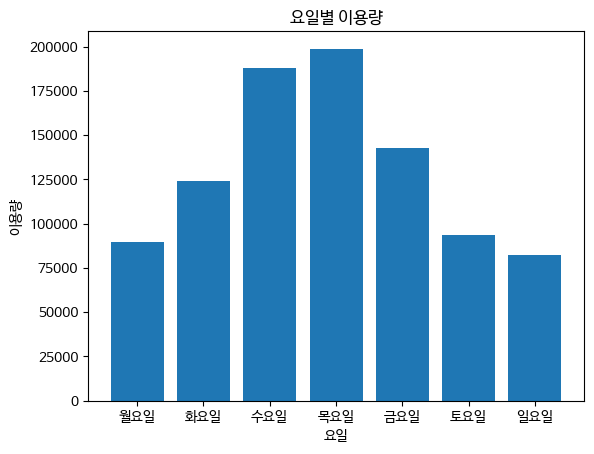

In [25]:
import matplotlib.pyplot as plt

## 요일별 이용량 막대 그래프 생성
plt.bar(day_df.index, day_df.values)

plt.title('요일별 이용량')
plt.xlabel('요일')
plt.ylabel('이용량')
plt.show()

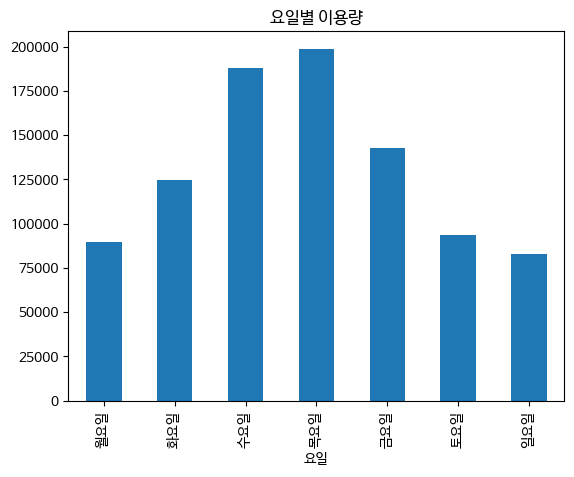

In [28]:
## Dataframe의 plot을 이용한 요일별 이용량 막대 그래프 생성
day_df.plot(kind='bar')
plt.title('요일별 이용량')
plt.show()

## 12-8 시간별 이용량 분석 및 시각화

시간별 이용량:
 출발_시
0     15861
1      9878
2      6537
3      4964
4      4218
5     10336
6     25656
7     56408
8     84611
9     50621
10    36809
11    41195
12    42644
13    43562
14    41770
15    46880
16    56258
17    72632
18    77134
19    53172
20    42217
21    40208
22    34700
23    21607
Name: count, dtype: int64


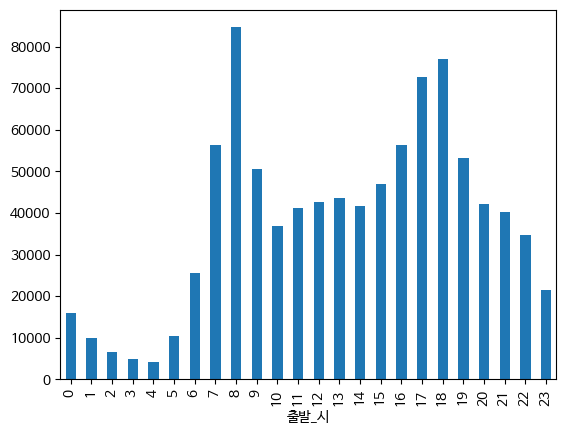

In [30]:
## '출발_시' 컬럼 생성 (기준_시간대 // 100)
df['출발_시'] = df['기준_시간대'] // 100
## 시간별 이용량 계산 및 정렬 (hour_df로 저장)
hour_df = df['출발_시'].value_counts().sort_index()
## 시간별 이용량 출력
print("시간별 이용량:\n", hour_df)

## 시간별 이용량 막대 그래프 생성
hour_df.plot(kind='bar')
plt.show()

## 12-9 일자별 이용량 분석 및 시각화

일자별 이용량:
 기준_날짜
2025-10-01    46727
2025-10-02    47724
2025-10-03    20899
2025-10-04    24926
2025-10-05    12195
2025-10-06     2687
2025-10-07     6678
2025-10-08    22995
2025-10-09    24683
2025-10-10     4609
2025-10-11    14219
2025-10-12    23681
2025-10-13     9750
2025-10-14    37491
2025-10-15    35745
2025-10-16    41929
2025-10-17    33384
2025-10-18    24375
2025-10-19    26168
2025-10-20    39893
2025-10-21    40923
2025-10-22    41847
2025-10-23    43353
2025-10-24    42939
2025-10-25    29966
2025-10-26    20542
2025-10-27    37337
2025-10-28    39321
2025-10-29    40814
2025-10-30    41203
2025-10-31    40875
Name: count, dtype: int64


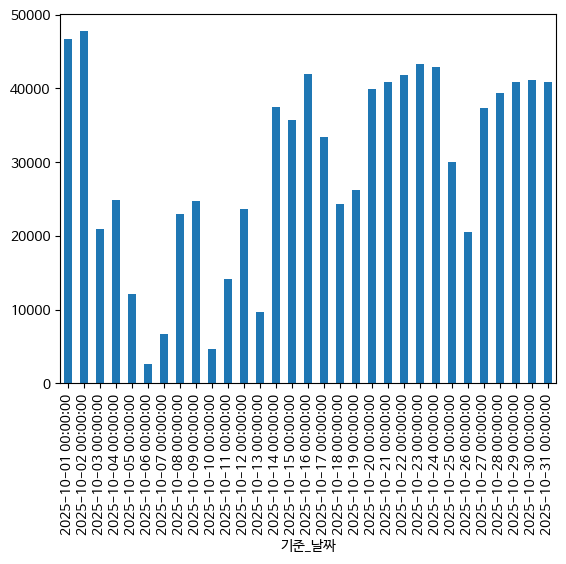

In [31]:
## 일자별 이용량 계산 및 정렬
daily_usage_df = df['기준_날짜'].value_counts().sort_index()
## 일자별 이용량 출력
print("일자별 이용량:\n", daily_usage_df)

## 일자별 이용량 막대 그래프 생성
daily_usage_df.plot(kind='bar')
plt.show()

# 3. 연계 분석

- 기상청 기상자료개방포탈 자료 수집
  - 기후통계분석 > 통계분석 > 조건별통계
  - https://data.kma.go.kr/climate/RankState/selectRankStatisticsDivisionList.do?pgmNo=179
  - 지역/지점 : 서울
  - 요소 : 강수량
  - 기간 : 일, 2023년 ~ 2023년
  - 조건 : 04월, 01 ~ 31일
- 다운로드 후 파일명 `seoul_rain_2023_04.csv`로 변경하여 colab에 업로드

## 12-10 강수량 데이터 로드

In [34]:
## 강수량 데이터 CSV 파일 로드
file_path = 'extremum_20251205013256.csv'
rain_df = pd.read_csv(file_path, encoding='cp949', skiprows=12)
rain_df.head(5)

,\t지점번호,지점명,일시,강수량(mm),1시간최다강수량(mm),1시간최다강수량시각,Unnamed: 6
0,108,서울,2025-01-01,NaN,NaN,NaN,NaN
1,108,서울,2025-01-02,NaN,NaN,NaN,NaN
2,108,서울,2025-01-03,0.0,NaN,NaN,NaN
3,108,서울,2025-01-04,NaN,NaN,NaN,NaN
4,108,서울,2025-01-05,6.7,NaN,NaN,NaN


## 12-11 강수량 데이터 전처리

In [43]:
## '일시' 컬럼 datetime 형식으로 변환
rain_df['일시'] = pd.to_datetime(rain_df['일시'], format='%Y-%m-%d')
## '강수량(mm)' 컬럼 결측치 0으로 채우기
rain_df['강수량(mm)'] = rain_df['강수량(mm)'].fillna(0)
## 불필요한 컬럼 제거
rain_df.drop(columns=['\t지점번호', 'Unnamed:  6'], inplace=True)

## 12-12 일자별 이용량 데이터와 강수량 데이터 병합

In [44]:
## 일자별 이용량과 강수량 데이터 병합 (daily_usage_gf의 기준_날짜, rain_df의 일시를 기준으로 결합)
merged_df = pd.merge(daily_usage_df, rain_df, how='left', left_on='기준_날짜', right_on='일시')
## 'count' 컬럼명 '이용량'으로 변경
merged_df.rename(columns={'count': '이용량'}, inplace=True)
## 병합된 데이터프레임 상위 5행 출력
merged_df.head(5)

,이용량,지점명,일시,강수량(mm),1시간최다강수량(mm),1시간최다강수량시각
0,46727,서울,2025-10-01,0.0,NaN,NaN
1,47724,서울,2025-10-02,0.0,NaN,NaN
2,20899,서울,2025-10-03,0.8,0.3,03:30
3,24926,서울,2025-10-04,0.0,0.0,NaN
4,12195,서울,2025-10-05,18.1,10.4,10:01


## 12-13 이용량 및 강수량 시각화

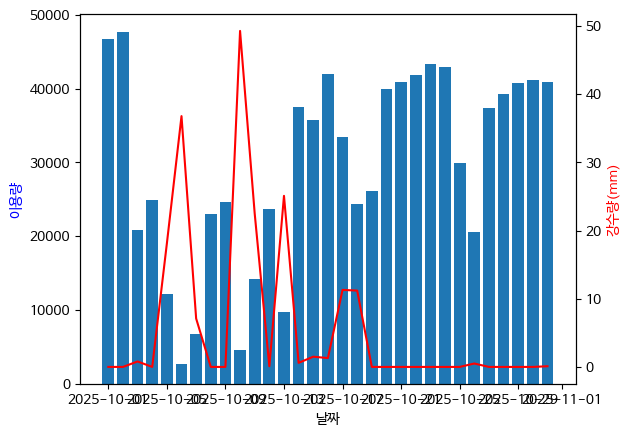

In [48]:
## 두 개의 y축을 가진 서브플롯 생성
fig, ax1 = plt.subplots()
ax2 = ax1.twinx() ## 두 번째 y축 생성

## 첫 번째 y축에 이용량 막대 그래프 그리기
ax1.bar(merged_df['일시'], merged_df['이용량'])
## 두 번째 y축에 강수량 꺾은선 그래프 그리기
ax2.plot(merged_df['일시'], merged_df['강수량(mm)'], color='r')

## x축 및 y축 레이블 설정
ax1.set_xlabel('날짜')
ax1.set_ylabel('이용량', color='b')
ax2.set_ylabel('강수량(mm)', color='r')

## 그래프 표시
plt.show()

## 12-14 강수량과 이용량 상관관계 분석

강수량과 이용량의 상관계수: -0.7363226333181104


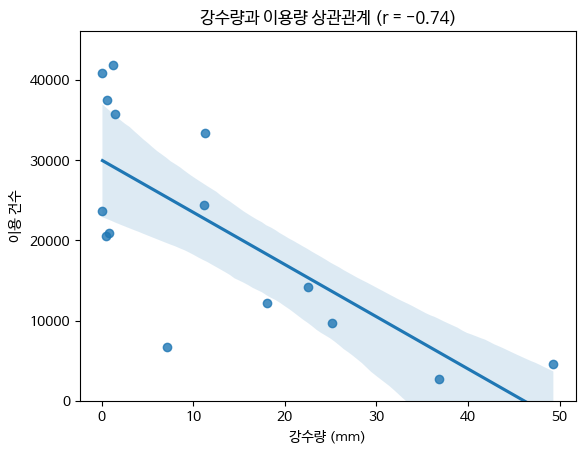

In [50]:
import seaborn as sns ## seaborn 라이브러리 임포트

## 강수량이 있는 날만 필터링
merged_onlyrain_df = merged_df[merged_df['강수량(mm)'] > 0]
## 강수량과 이용량의 상관계수 계산
corr = merged_onlyrain_df['이용량'].corr(merged_onlyrain_df['강수량(mm)'])
## 상관계수 출력
print("강수량과 이용량의 상관계수:", corr)

## 강수량과 이용량의 회귀선 그래프 생성
sns.regplot(x='강수량(mm)', y='이용량', data=merged_onlyrain_df)

## y축 범위 설정
plt.ylim(0, merged_onlyrain_df['이용량'].max()*1.1)

## 그래프 제목 및 축 레이블 설정
plt.title(f'강수량과 이용량 상관관계 (r = {corr:.2f})')
plt.xlabel('강수량 (mm)')
plt.ylabel('이용 건수')
## 그래프 표시
plt.show()

## 12-15 OLS 회귀 모델 생성 및 분석 및 귀무가설 검증

In [51]:
import statsmodels.formula.api as smf ## statsmodels.formula.api 임포트

## 컬럼명 변경: '강수량(mm)' -> '강수량_mm' (formula API 호환을 위해)
merged_onlyrain_df = merged_onlyrain_df.copy()
merged_onlyrain_df.rename(columns={'강수량(mm)': '강수량_mm'}, inplace=True)

## OLS 모델 정의 및 학습
model = smf.ols(formula='이용량 ~ 강수량_mm', data=merged_onlyrain_df)
results = model.fit()

## 모델 요약 결과 출력
print(results.summary())

## 귀무가설 검증 해석
## 강수량_mm 계수에 대한 p-value를 확인하여 귀무가설 (강수량이 이용량에 미치는 영향이 0이다) 검증
## 일반적으로 p-value가 0.05 미만이면 귀무가설을 기각하고 유의미한 영향이 있다고 해석
print("\n--- 귀무가설 검증 (강수량 계수) ---")
p_value = results.pvalues['강수량_mm']
print(f"강수량_mm 계수의 p-value: {p_value:.4f}")
if p_value < 0.05:
    print("p-value가 0.05보다 작으므로 귀무가설을 기각합니다.")
    print("즉, 강수량은 자전거 이용량에 통계적으로 유의미한 영향을 미칩니다.")
else:
    print("p-value가 0.05보다 크므로 귀무가설을 기각할 수 없습니다.")
    print("즉, 강수량은 자전거 이용량에 통계적으로 유의미한 영향을 미치지 않는다고 볼 수 있습니다.")

                            OLS Regression Results                            
Dep. Variable:                    이용량   R-squared:                       0.542
Model:                            OLS   Adj. R-squared:                  0.507
Method:                 Least Squares   F-statistic:                     15.39
Date:                Thu, 04 Dec 2025   Prob (F-statistic):            0.00175
Time:                        16:45:26   Log-Likelihood:                -157.53
No. Observations:                  15   AIC:                             319.1
Df Residuals:                      13   BIC:                             320.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   3.003e+04   3196.910      9.394      0.0